In [20]:
import pandas as pd
import numpy as np
from tools.preprocessing_data import encode_data_to_numeric, get_data_since_date, load_data
from tools.add_external_data import add_external_data
from sklearn.decomposition import PCA
from factor_analyzer.rotator import Rotator
from sklearn.preprocessing import MinMaxScaler

/Users/inagege/Documents/00_Uni/SeminarSocialSentimentInTimesOfCrisis/tools/preprocessing_data.py:19: DtypeWarning: Columns (55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,73,74,75,148,161,166) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("../Data/data_sample_700_SOSEC_dataset_germany.csv")
[*********************100%***********************]  1 of 1 completed


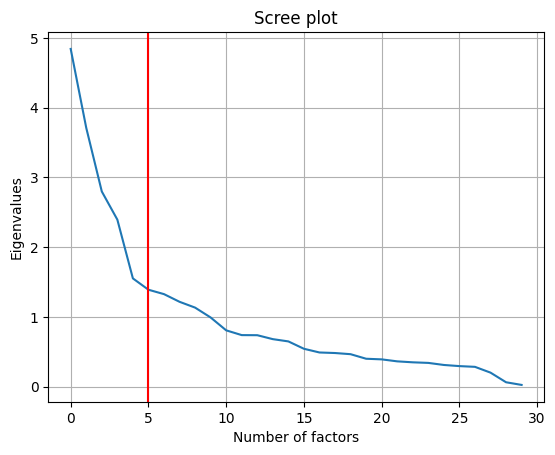

Eigenvalues: [4.84178287 3.71051933 2.79868931 2.39497883 1.55274111 1.3904413
 1.32738161 1.21739735 1.13415533 0.9927763  0.80827971 0.74007138
 0.73866362 0.68221462 0.64965396 0.54417689 0.4910382  0.48329661
 0.46664282 0.40127356 0.3924018  0.36389616 0.35009561 0.34174239
 0.31212971 0.2957853  0.28524224 0.2022397  0.0641674  0.026125  ]
Eigenvalues > 1 (Kaiser criterion): [4.84178287 3.71051933 2.79868931 2.39497883 1.55274111 1.3904413
 1.32738161 1.21739735 1.13415533]
Number of factors according to Kaiser criterion: 9


In [21]:
data = load_data()
data = add_external_data(data)
data = get_data_since_date(data, '2023-01-01')
data = encode_data_to_numeric(data)

#relevant_columns = ['consumer_price_index', 'inflation_rate', 'dax_points', 'interest_rate', 'F3A21_1', 'F71invest', 'F5A10_2', 'F5aA1_1', 'F5aA2_1', 'F5aA3_1', 'F5aA4_1', 'F5aA5_1', 'F5bA1_1','F5bA2_1' ,'F5bA3_1' ,'F5bA4_1' ,'F5bA5_1']
#relevant_columns = ['inflation_rate', 'interest_rate', 'dax_points', 'MSCI_world', 'F3A21_1', 'F5A10_2', 'F5aA1_1', 'F5aA2_1', 'F5aA3_1', 'F5bA1_1', 'F5bA2_1', 'F5bA3_1', 'F5bA4_1', 'F5bA5_1', 'F5A10_1', 'F5A11_1', 'F5A12_1', 'F5A13_1', 'F5A14_1', 'F3A16_1', 'F3A17_1', 'F2A6', 'F2A14', 'F1A13_1', 'F1A14_1']
relevant_columns = ['inflation_rate', 'interest_rate', 'dax_points', 'MSCI_world','F3A21_1', 'F5A10_2', 'F5aA1_1', 'F5aA2_1', 'F5aA3_1', 'F5bA1_1','F5bA2_1' ,'F5bA3_1' ,'F5bA4_1' ,'F5bA5_1', 'F5A10_1', 'F5A11_1', 'F5A12_1', 'F5A13_1', 'F5A14_1',  'F3A16_1', 'F3A17_1', 'F3A15_1',  'F2A6', 'F2A14', 'F2A7', 'F3A22_1', 'F3A14_1', 'F1A13_1', 'F1A14_1', 'F3A20_1']

data = data[relevant_columns]

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

correlation_matrix = data.corr()
correlation_matrix.fillna(0, inplace=True)

# Calculate eigenvalues of the correlation matrix
eigenvalues, _ = np.linalg.eig(correlation_matrix)

#sort eigenvalues
eigenvalues = np.sort(eigenvalues)[::-1]

#plot eigenvalues
import matplotlib.pyplot as plt
plt.plot(eigenvalues)
plt.title('Scree plot')
plt.xlabel('Number of factors')
plt.ylabel('Eigenvalues')
plt.grid()

#plt.axhline(y=2.5, color='g', linestyle='-')

#insert a vertical line at x=15
plt.axvline(x=5, color='r', linestyle='-')

plt.show()

# Apply Kaiser criterion: keep factors with eigenvalues > 1
kaiser_factors = eigenvalues[eigenvalues > 1]
print("Eigenvalues:", eigenvalues)
print("Eigenvalues > 1 (Kaiser criterion):", kaiser_factors)
print("Number of factors according to Kaiser criterion:", len(kaiser_factors))

#fill nans in each column which includes only 1s and 0s with mod and other columns with mean
for column in data.columns:
    if set(data[column].dropna(inplace=False).unique()) <= {0, 1}:
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].mean())

In [22]:
#fill data nans before applying PCA
pca = PCA(n_components=10)
#pca = PCA(n_components=20)
pca.fit(data)

# Get the component matrix
component_matrix = pca.components_.T

# Add a small epsilon value to avoid numerical instability
epsilon = 1e-100
component_matrix += epsilon

rotator = Rotator()
rotated_matrix = rotator.fit_transform(component_matrix)

# Create a DataFrame for the rotated component matrix
rotated_matrix_df = pd.DataFrame(rotated_matrix, 
                                 index=data.columns, 
                                 columns=[f'Component {i+1}' for i in range(10)])

print(rotated_matrix_df)

                Component 1  Component 2  Component 3  Component 4  \
inflation_rate     0.003532     0.010283     0.602105     0.017159   
interest_rate      0.010859     0.000036    -0.478460    -0.042003   
dax_points         0.000955    -0.000067    -0.358187     0.034478   
MSCI_world         0.000338     0.000674    -0.522162     0.028309   
F3A21_1            0.101853     0.028124    -0.012984    -0.001090   
F5A10_2            0.090527     0.047342    -0.012648     0.015293   
F5aA1_1           -0.454846    -0.072662     0.008910    -0.038642   
F5aA2_1           -0.633788     0.068393    -0.012198     0.111353   
F5aA3_1            0.056713     0.413707     0.013714     0.053194   
F5bA1_1           -0.008580     0.064145    -0.003628    -0.000643   
F5bA2_1            0.052891     0.600581    -0.002930     0.046740   
F5bA3_1           -0.123668     0.623325    -0.015354    -0.124365   
F5bA4_1           -0.564640    -0.020845     0.009179    -0.040646   
F5bA5_1           -0

In [23]:
# Assign each feature to the component with the highest value
assigned_components = rotated_matrix_df.idxmax(axis=1)

# Create a new DataFrame to show the assignment
assigned_components_df = pd.DataFrame({'Assigned Component': assigned_components})
assigned_components_df = assigned_components_df.reset_index()
assigned_components_df.columns = ['Feature', 'Assigned Component']
print(assigned_components_df)

           Feature Assigned Component
0   inflation_rate        Component 3
1    interest_rate        Component 9
2       dax_points        Component 4
3       MSCI_world        Component 4
4          F3A21_1        Component 1
5          F5A10_2        Component 1
6          F5aA1_1        Component 7
7          F5aA2_1        Component 9
8          F5aA3_1        Component 2
9          F5bA1_1        Component 6
10         F5bA2_1        Component 2
11         F5bA3_1        Component 2
12         F5bA4_1        Component 7
13         F5bA5_1        Component 7
14         F5A10_1        Component 5
15         F5A11_1        Component 5
16         F5A12_1        Component 9
17         F5A13_1        Component 6
18         F5A14_1        Component 2
19         F3A16_1        Component 5
20         F3A17_1        Component 5
21         F3A15_1        Component 2
22            F2A6        Component 4
23           F2A14        Component 4
24            F2A7        Component 4
25         F

In [24]:
# Create a new DataFrame with components as columns and features as rows
components = assigned_components_df['Assigned Component'].unique()
features = assigned_components_df.index
boolean_df = pd.DataFrame(False, index=features, columns=components)

# Populate the DataFrame with True where the feature is assigned to the component
for feature, component in assigned_components_df['Assigned Component'].items():
    boolean_df.loc[feature, component] = True

print(boolean_df)

    Component 3  Component 9  Component 4  Component 1  Component 7  \
0          True        False        False        False        False   
1         False         True        False        False        False   
2         False        False         True        False        False   
3         False        False         True        False        False   
4         False        False        False         True        False   
5         False        False        False         True        False   
6         False        False        False        False         True   
7         False         True        False        False        False   
8         False        False        False        False        False   
9         False        False        False        False        False   
10        False        False        False        False        False   
11        False        False        False        False        False   
12        False        False        False        False         True   
13    

In [25]:
# Load the CSV file into a DataFrame
feature_meanings_df = pd.read_csv('../Data/SOSEC_Codebook_Germany_2024_May.csv', delimiter=';')

# Drop duplicate rows based on the 'Feature' column, keeping only the last occurrence
feature_meanings_df = feature_meanings_df.drop_duplicates(subset='Feature', keep='last')

# Merge the DataFrame
merged_df = assigned_components_df.merge(feature_meanings_df, on='Feature', how='left')
merged_df.drop(columns=['Unnamed: 2'], inplace=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('../results/ECA/seminar_paper/relevant_features_kaiser.csv', index=False)
print(merged_df.head(10))

          Feature Assigned Component  \
0  inflation_rate        Component 3   
1   interest_rate        Component 9   
2      dax_points        Component 4   
3      MSCI_world        Component 4   
4         F3A21_1        Component 1   
5         F5A10_2        Component 1   
6         F5aA1_1        Component 7   
7         F5aA2_1        Component 9   
8         F5aA3_1        Component 2   
9         F5bA1_1        Component 6   

                                            question  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4   Aktuell ergibt es Sinn in Aktien zu investieren.  
5                                   Die Aktienmärkte  
6  ...von öffentlichen Medienanstalten  (ARD, ZDF...  
7  ...von privaten etablierten Medienanstalten  (...  
8  ...von alternativen Anbietern (newsblogger, so...  
9        